<H3>На данном шаге создадим модели NLP, оценим результат</H3>

Для этого мы будем использовать метод:

1. **TF-IDF** (Term Frequency-Inverse Document Frequency). 

Этот метод преобразует текст в вектор чисел, учитывая как частоту встречаемости слова в документе, так и его важность для всего корпуса.


Этапы:
1. Подготовка данных: Разделение данных на обучающую и тестовую выборки.
2. Векторизация: Применение метода для преобразования текстовых данных в числовую форму.
3. Моделирование: Обучение модели классификации на обучающей выборке.
4. Оценка: Проверка качества модели на тестовой выборке.сте.

In [1]:
import joblib
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC

from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Папка для сохранения фото
PHOTO_FOLDER = 'images/'

# Папка для сохранения моделей
MODELS_FOLDER = 'models/'

In [4]:
df = pd.read_csv('datasets/step_2.csv',
                 encoding="utf-8", low_memory=False)

In [5]:
df.sample(n=2).T

,280712,3723354
Исполнитель,общество с ограниченной ответственностью профс...,общество с ограниченной ответственностью агроопт
Заказчик,миц пфр,бу урайский социально-реабилитационный центр д...
Заказ,Оказание услуг по техническому обслуживанию об...,Поставка молочной продукции
Описание y,Услуги по обеспечению безопасности и проведени...,Продукты пищевые
Группа по ОКПД,Прочее,Прочее
y,80.2,10.5


In [6]:
stop_words = stopwords.words('russian')

# TF-IDF

## Чистый

Попробуем базовый случай TF-IDF на описании заказа, без добавления других полей, которые могут помочь

In [7]:
# Выбор основных столбцов для анализа и разделение данных
X = df['Заказ'] # Текстовое описание закупок
y = df['Группа по ОКПД']  # Группы

# Разделение данных на обучающую и тестовую выборки (80% - обучающая, 20% - тестовая)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape

((8701164,), (2175291,))

In [8]:
%%time
# Инициализация TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(max_features=10000, stop_words=stop_words)

# Преобразование текстовых данных в числовую форму с помощью TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

CPU times: total: 1min 32s
Wall time: 1min 33s


((8701164, 10000), (2175291, 10000))

In [9]:
# Сохраним модель
filename = MODELS_FOLDER + 'tfidf_vectorizer.sav'
joblib.dump(tfidf_vectorizer, filename)

['models/tfidf_vectorizer.sav']

In [10]:
# Ищем уникальные классы, это понадобится при выводе результатов
unique_classes, counts = np.unique(y_train, return_counts=True)
target_names = unique_classes.tolist()

Т.к. у нас был дисбаланс классов, для ускорения работы и демонстрации обрежем группу "Прочее" до размера другой наибольшей группы

In [11]:
# Определим размер второй наибольшей группы
group_sizes = y.value_counts()
second_largest_group_size = group_sizes.sort_values(ascending=False).iloc[1]

# Увеличим этот размер на 20%
desired_size = int(second_largest_group_size * 1.2)

# Отберем соответствующее количество записей из группы "Прочее"
sampled_other_group = y[y == "Прочее"].sample(desired_size)

# Отберем все записи, которые не относятся к группе "Прочее"
not_other_group = y[y != "Прочее"]

# Объединим отобранные записи с записями из других групп
new_y = pd.concat([sampled_other_group, not_other_group])

# Теперь отберем соответствующие записи из X_train
new_X = X[new_y.index]

# Разделение данных на обучающую и тестовую выборки (80% - обучающая, 20% - тестовая)
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42, stratify=new_y)

X_train.shape, X_test.shape

((913520,), (228380,))

In [12]:
group_sizes

Группа по ОКПД
Прочее                                  10200835
Строительно-монтажные работы (СМР)        388567
Подключение коммуникаций                  149919
Проектно-изыскательские работы (ПИР)       90399
Строительный надзор                        46735
Name: count, dtype: int64

In [13]:
# Преобразование текстовых данных в числовую форму с помощью TF-IDF
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((913520, 10000), (228380, 10000))

In [14]:
# Ищем уникальные классы, это понадобится при выводе результатов
unique_classes, counts = np.unique(y_train, return_counts=True)
target_names = unique_classes.tolist()

### LogReg

In [15]:
%%time
# Инициализация и обучение модели логистической регрессии
logreg = LogisticRegression(max_iter=10000, random_state=42)
logreg.fit(X_train_tfidf, y_train)

# Предсказание на тестовой выборке
y_pred = logreg.predict(X_test_tfidf)

CPU times: total: 7min 46s
Wall time: 1min 59s


In [16]:
# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=target_names)

In [17]:
print(accuracy)

0.9232726158157457


In [18]:
print(class_report)

                                      precision    recall  f1-score   support

            Подключение коммуникаций       0.81      0.76      0.78     29984
Проектно-изыскательские работы (ПИР)       0.95      0.92      0.93     18080
                              Прочее       0.97      0.97      0.97     93256
  Строительно-монтажные работы (СМР)       0.90      0.93      0.92     77713
                 Строительный надзор       0.95      0.96      0.95      9347

                            accuracy                           0.92    228380
                           macro avg       0.92      0.91      0.91    228380
                        weighted avg       0.92      0.92      0.92    228380



In [19]:
# Сохраним модель
filename = MODELS_FOLDER + 'logreg_model.sav'
joblib.dump(logreg, filename)

['models/logreg_model.sav']

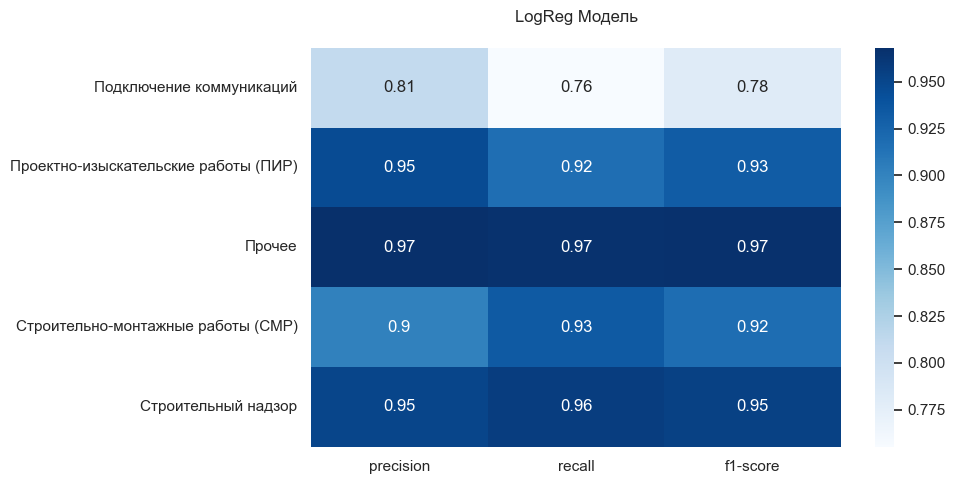

In [20]:
clf_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
clf_df = pd.DataFrame(clf_report).iloc[:-1, :].T
# Удаление ненужных строк и столбца 'support'
clf_df = clf_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)  # убираем ненужные строки

# Визуализация с помощью heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(clf_df, annot=True, cmap='Blues')
plt.title('LogReg Модель\n')

# Сохранение графика
plt.tight_layout()
plt.savefig(PHOTO_FOLDER + "logreg.png", bbox_inches="tight")
plt.show()

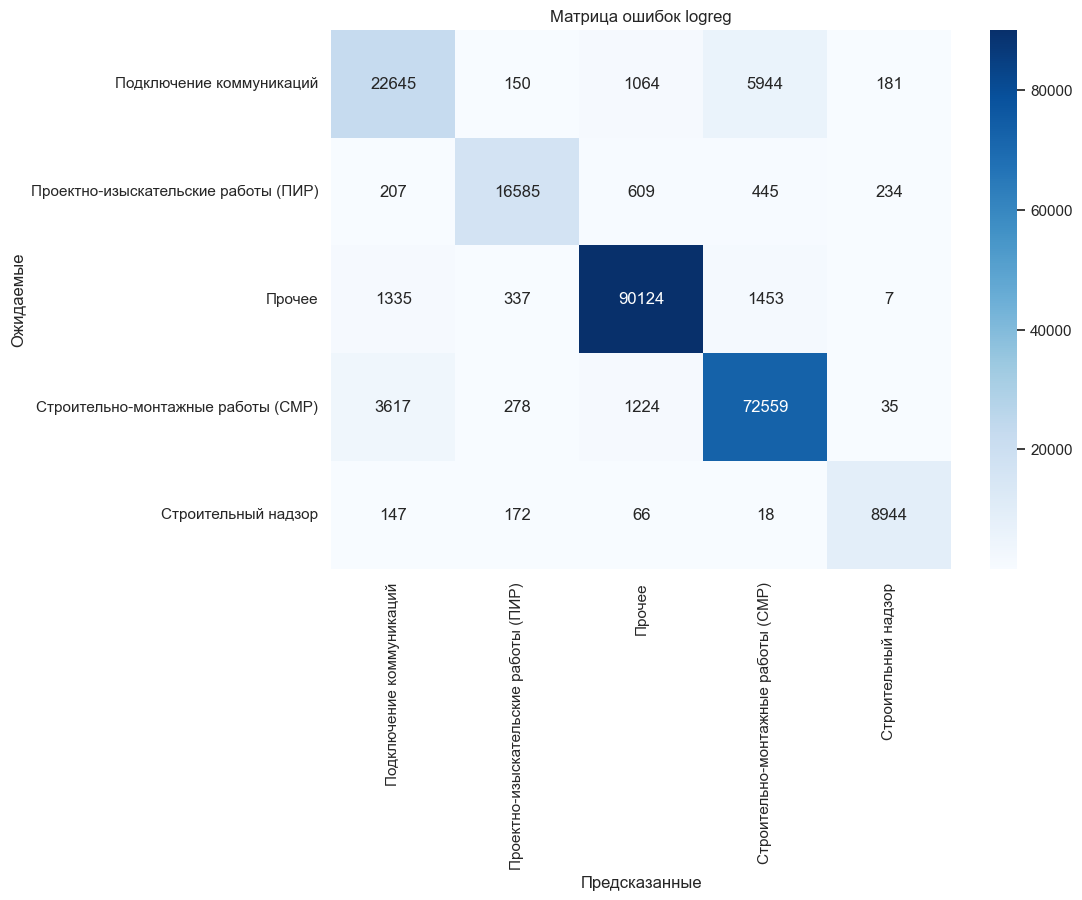

In [21]:
# Выводим матрицу ошибок
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Ожидаемые')
plt.xlabel('Предсказанные')
plt.title('Матрица ошибок logreg')

plt.savefig(PHOTO_FOLDER + "logreg_cm.png", bbox_inches="tight")
plt.show()

### SGD

In [22]:
%%time

# Инициализация и обучение модели
sgd_clf = SGDClassifier(max_iter=15000, random_state=42)
sgd_clf.fit(X_train_tfidf, y_train)

CPU times: total: 7.89 s
Wall time: 5 s


SGDClassifier(max_iter=15000, random_state=42)

In [23]:
# Предсказание на тестовой выборке
y_pred_sgd = sgd_clf.predict(X_test_tfidf)

In [24]:
# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred_sgd)
class_report = classification_report(y_test, y_pred_sgd, target_names=target_names)

In [25]:
print(accuracy)

0.906962080742622


In [26]:
print(class_report)

                                      precision    recall  f1-score   support

            Подключение коммуникаций       0.80      0.69      0.74     29984
Проектно-изыскательские работы (ПИР)       0.95      0.86      0.90     18080
                              Прочее       0.95      0.96      0.96     93256
  Строительно-монтажные работы (СМР)       0.88      0.93      0.90     77713
                 Строительный надзор       0.93      0.95      0.94      9347

                            accuracy                           0.91    228380
                           macro avg       0.90      0.88      0.89    228380
                        weighted avg       0.91      0.91      0.91    228380



In [27]:
# Сохраним модель
filename = MODELS_FOLDER + 'sgd_model.sav'
joblib.dump(sgd_clf, filename)

['models/sgd_model.sav']

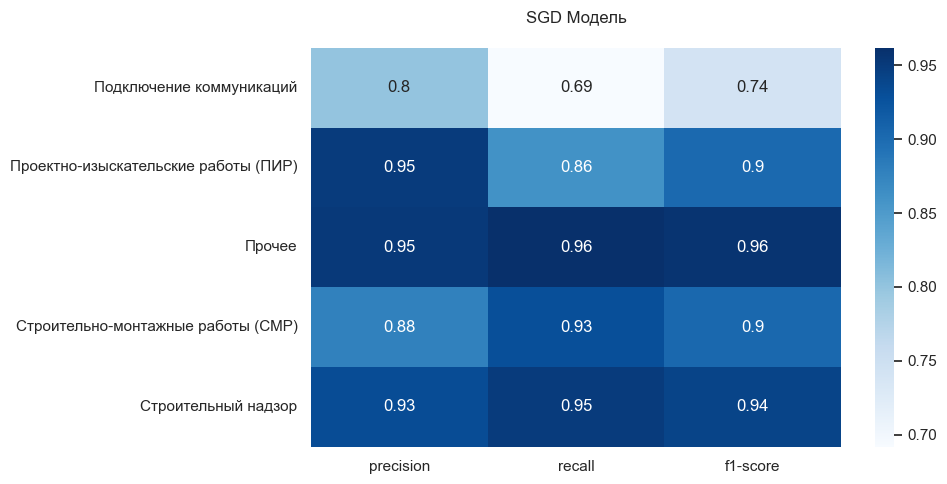

In [28]:
clf_report = classification_report(y_test, y_pred_sgd, target_names=target_names, output_dict=True)
clf_df = pd.DataFrame(clf_report).iloc[:-1, :].T
# Удаление ненужных строк и столбца 'support'
clf_df = clf_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)  # убираем ненужные строки

# Визуализация с помощью heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(clf_df, annot=True, cmap='Blues')
plt.title('SGD Модель\n')

# Сохранение графика
plt.tight_layout()
plt.savefig(PHOTO_FOLDER + "sgd.png", bbox_inches="tight")
plt.show()

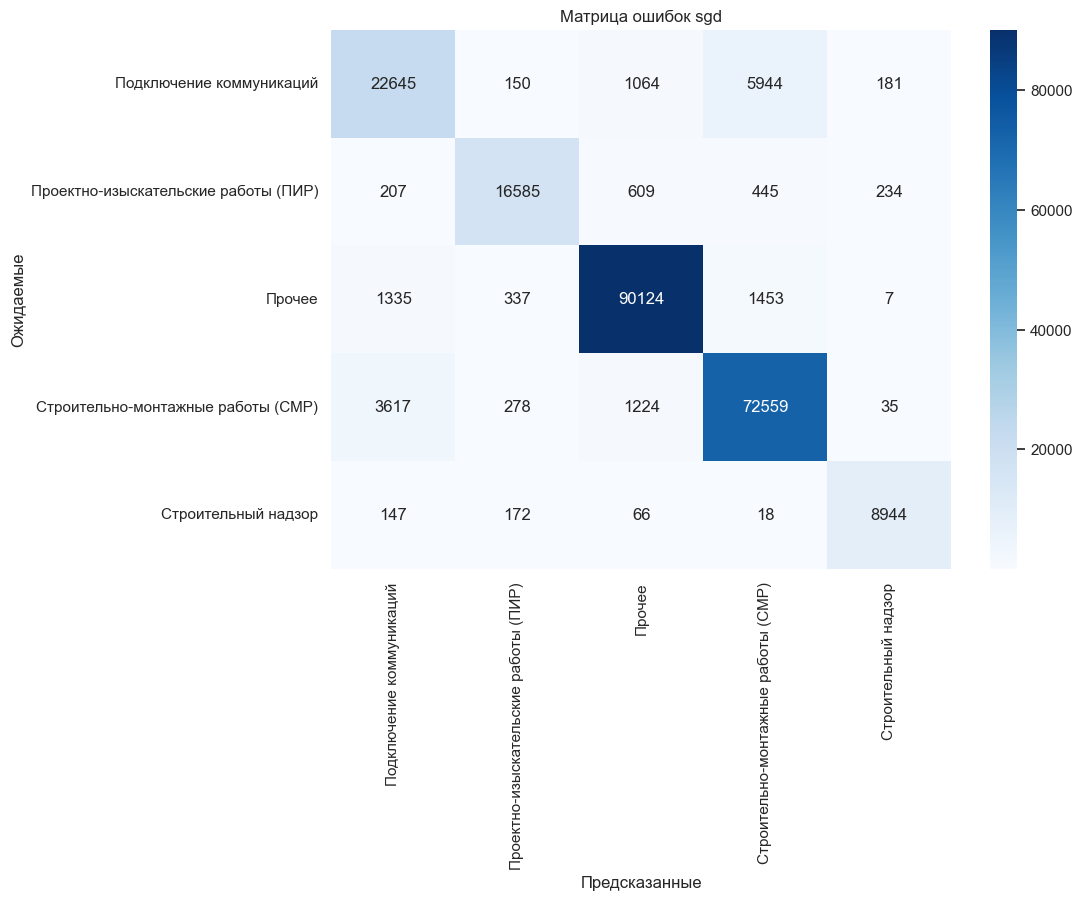

In [29]:
# Выводим матрицу ошибок
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Ожидаемые')
plt.xlabel('Предсказанные')
plt.title('Матрица ошибок sgd')

plt.savefig(PHOTO_FOLDER + "sgd_cm.png", bbox_inches="tight")
plt.show()

## С дополнительными полями

Добавим другие поля из данных

In [30]:
# Выбор основных столбцов для анализа и разделение данных
X = df['Исполнитель'] + ' ' + df['Заказчик'] + ' ' + df['Заказ'] # Текстовое описание закупок
y = df['Группа по ОКПД']  # Группы

# Разделение данных на обучающую и тестовую выборки (80% - обучающая, 20% - тестовая)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train.shape, X_test.shape

((8701164,), (2175291,))

In [31]:
%%time
# Инициализация TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(max_features=10000,
                                   stop_words=stop_words, lowercase=True)

# Преобразование текстовых данных в числовую форму с помощью TF-IDF
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

CPU times: total: 2min 11s
Wall time: 2min 12s


In [32]:
# Ищем уникальные классы, это понадобится при выводе результатов
unique_classes, counts = np.unique(y_train, return_counts=True)
target_names = unique_classes.tolist()

Т.к. у нас был дисбаланс классов, для ускорения работы и демонстрации обрежем группу "Прочее" до размера другой наибольшей группы

In [33]:
# Определим размер второй наибольшей группы
group_sizes = y.value_counts()
second_largest_group_size = group_sizes.sort_values(ascending=False).iloc[1]

# Увеличим этот размер на 20%
desired_size = int(second_largest_group_size * 1.2)

# Отберем соответствующее количество записей из группы "Прочее"
sampled_other_group = y[y == "Прочее"].sample(desired_size)

# Отберем все записи, которые не относятся к группе "Прочее"
not_other_group = y[y != "Прочее"]

# Объединим отобранные записи с записями из других групп
new_y = pd.concat([sampled_other_group, not_other_group])

# Теперь отберем соответствующие записи из X_train
new_X = X[new_y.index]

# Разделение данных на обучающую и тестовую выборки (80% - обучающая, 20% - тестовая)
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.2, random_state=42, stratify=new_y)

X_train.shape, X_test.shape

((913520,), (228380,))

In [34]:
group_sizes

Группа по ОКПД
Прочее                                  10200835
Строительно-монтажные работы (СМР)        388567
Подключение коммуникаций                  149919
Проектно-изыскательские работы (ПИР)       90399
Строительный надзор                        46735
Name: count, dtype: int64

In [35]:
new_y.value_counts()

Группа по ОКПД
Прочее                                  466280
Строительно-монтажные работы (СМР)      388567
Подключение коммуникаций                149919
Проектно-изыскательские работы (ПИР)     90399
Строительный надзор                      46735
Name: count, dtype: int64

In [36]:
# Преобразование текстовых данных в числовую форму с помощью TF-IDF
X_train_tfidf = tfidf_vectorizer.transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((913520, 10000), (228380, 10000))

In [37]:
# Ищем уникальные классы, это понадобится при выводе результатов
unique_classes, counts = np.unique(y_train, return_counts=True)
target_names = unique_classes.tolist()

## LogReg

In [38]:
%%time
# Инициализация и обучение модели логистической регрессии
logreg = LogisticRegression(max_iter=10000, random_state=42)
logreg.fit(X_train_tfidf, y_train)

# Предсказание на тестовой выборке
y_pred = logreg.predict(X_test_tfidf)

CPU times: total: 10min 18s
Wall time: 2min 40s


In [39]:
# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred)
class_report = classification_report(y_test, y_pred, target_names=target_names)

In [40]:
print(accuracy)

0.9209869515719415


In [41]:
print(class_report)

                                      precision    recall  f1-score   support

            Подключение коммуникаций       0.81      0.74      0.78     29984
Проектно-изыскательские работы (ПИР)       0.94      0.91      0.92     18080
                              Прочее       0.96      0.97      0.97     93256
  Строительно-монтажные работы (СМР)       0.90      0.93      0.92     77713
                 Строительный надзор       0.94      0.95      0.94      9347

                            accuracy                           0.92    228380
                           macro avg       0.91      0.90      0.91    228380
                        weighted avg       0.92      0.92      0.92    228380



In [42]:
# Сохраним модель
filename = MODELS_FOLDER + 'logreg_model_up.sav'
joblib.dump(logreg, filename)

['models/logreg_model_up.sav']

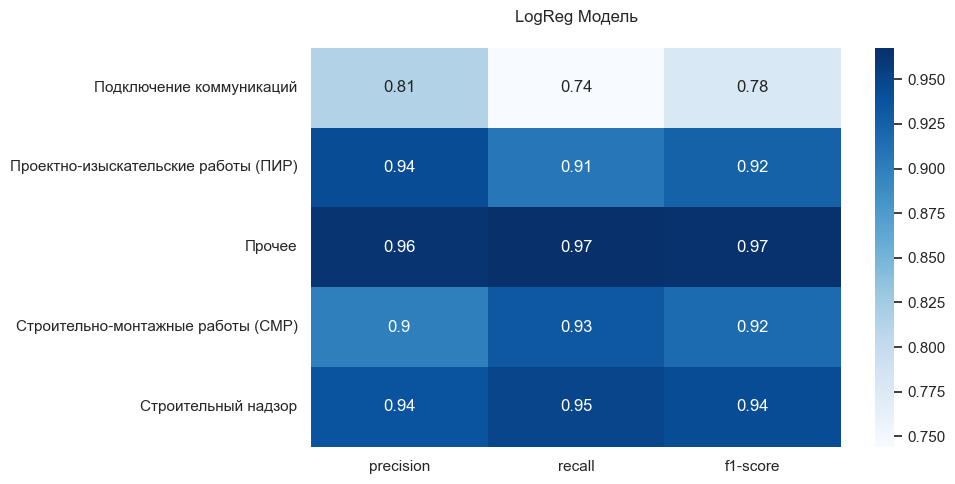

In [43]:
clf_report = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
clf_df = pd.DataFrame(clf_report).iloc[:-1, :].T
# Удаление ненужных строк и столбца 'support'
clf_df = clf_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)  # убираем ненужные строки

# Визуализация с помощью heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(clf_df, annot=True, cmap='Blues')
plt.title('LogReg Модель\n')

# Сохранение графика
plt.tight_layout()
plt.savefig(PHOTO_FOLDER + "logreg.png", bbox_inches="tight")
plt.show()

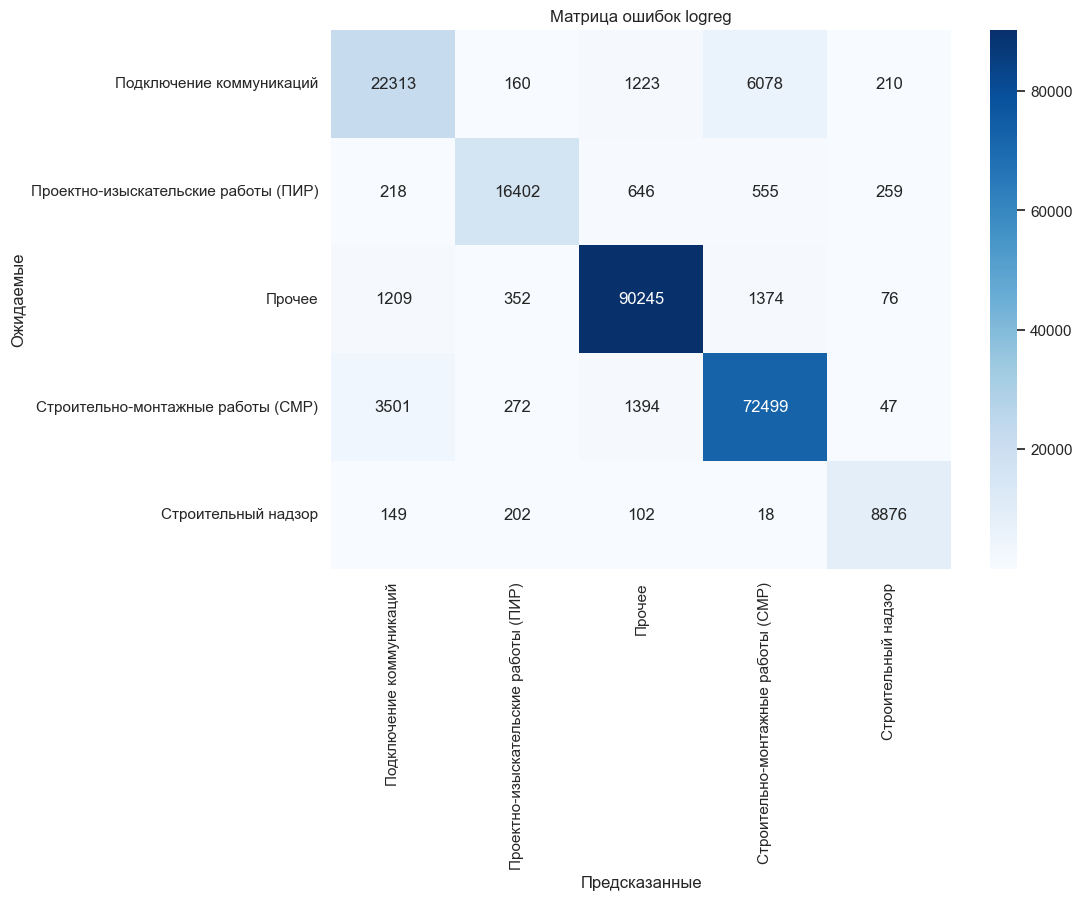

In [44]:
# Выводим матрицу ошибок
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Ожидаемые')
plt.xlabel('Предсказанные')
plt.title('Матрица ошибок logreg')

plt.savefig(PHOTO_FOLDER + "logreg_cm.png", bbox_inches="tight")
plt.show()

## SGD

In [45]:
%%time

# Инициализация и обучение модели
sgd_clf = SGDClassifier(max_iter=15000, random_state=42)
sgd_clf.fit(X_train_tfidf, y_train)

CPU times: total: 9.5 s
Wall time: 6.4 s


SGDClassifier(max_iter=15000, random_state=42)

In [46]:
# Предсказание на тестовой выборке
y_pred_sgd = sgd_clf.predict(X_test_tfidf)

In [47]:
# Оценка качества модели
accuracy = accuracy_score(y_test, y_pred_sgd)
class_report = classification_report(y_test, y_pred_sgd, target_names=target_names)

In [48]:
print(accuracy)

0.9001401173482791


In [49]:
print(class_report)

                                      precision    recall  f1-score   support

            Подключение коммуникаций       0.80      0.65      0.72     29984
Проектно-изыскательские работы (ПИР)       0.94      0.85      0.89     18080
                              Прочее       0.94      0.96      0.95     93256
  Строительно-монтажные работы (СМР)       0.87      0.93      0.90     77713
                 Строительный надзор       0.90      0.91      0.90      9347

                            accuracy                           0.90    228380
                           macro avg       0.89      0.86      0.87    228380
                        weighted avg       0.90      0.90      0.90    228380



In [50]:
# Сохраним модель
filename = MODELS_FOLDER + 'sgd_model_up.sav'
joblib.dump(sgd_clf, filename)

['models/sgd_model_up.sav']

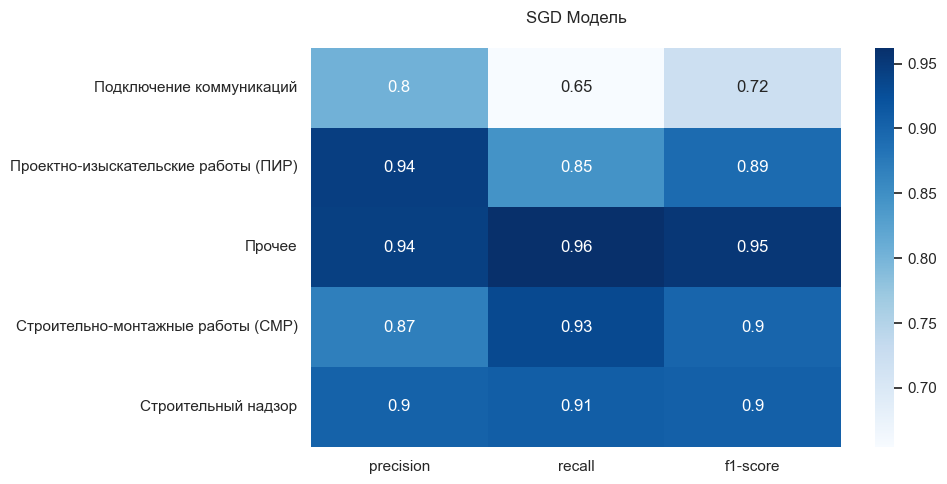

In [51]:
clf_report = classification_report(y_test, y_pred_sgd, target_names=target_names, output_dict=True)
clf_df = pd.DataFrame(clf_report).iloc[:-1, :].T
# Удаление ненужных строк и столбца 'support'
clf_df = clf_df.drop(['accuracy', 'macro avg', 'weighted avg'], axis=0)  # убираем ненужные строки

# Визуализация с помощью heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(clf_df, annot=True, cmap='Blues')
plt.title('SGD Модель\n')

# Сохранение графика
plt.tight_layout()
plt.savefig(PHOTO_FOLDER + "sgd.png", bbox_inches="tight")
plt.show()

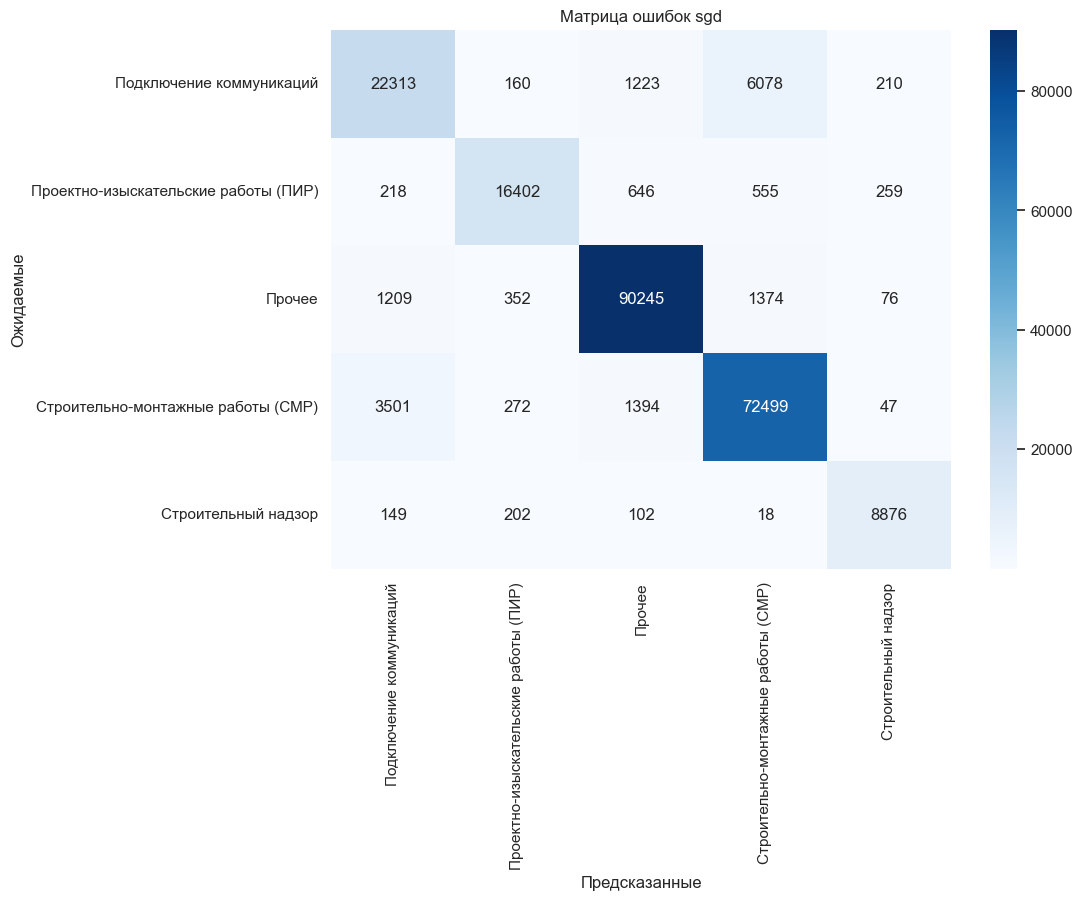

In [52]:
# Выводим матрицу ошибок
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.ylabel('Ожидаемые')
plt.xlabel('Предсказанные')
plt.title('Матрица ошибок sgd')

plt.savefig(PHOTO_FOLDER + "sgd_cm.png", bbox_inches="tight")
plt.show()

## Вывод

Добавление других данных не смогло принести улучшение в качестве работы, а сделало только хуже, поэтому откажемся от этой идеи

Используем предобученную модель, получаем вектора для слов.
На основе них строим модель машинного обучения

Можно сделать следующие выводы:

* Смогли обучить модель NLP для классификации текстов
* Провели анализ моделей, содержащих только тексты заказов, а также моделей с использованием текстов заказов, поставщиков и регионов
* В результате анализа выяснено, что "чистые" модели ведут себя несколько лучше, а также быстрее
* Лучшую точность показала "чистая" модель линейной регресии, с точностью в 92% по всем классам

В качестве дальнейшего улучшения точности работы предлагается использовать несколько решений:

* Модели FastText, которые понимают положение слов в предложении
* Модели BERT для векторизации текста с последующей классификацией методами машинного обучения
* Либо классификацией с помощью нейронных сетей